In [1]:
import os
import h5py as h5
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir
import numpy as np
from tqdm.notebook import tqdm
import torch

try:
    from gwpy.timeseries import TimeSeries
except ModuleNotFoundError: 
    !pip install --quiet gwpy
    from gwpy.timeseries import TimeSeries

In [2]:
def construct_dataframe(path,t_delta=None):
  name_data=[]
  starting_times_data=[]
  timeseries_data=[]
  type_data=[]
  for file in listdir(path):
    if file != '.ipynb_checkpoints':
        fout=h5.File(path+file,'r') 
    type_of_glitch=list(fout.keys())[0]
    dataset=fout[type_of_glitch]
    t = TimeSeries(dataset[()])
    ln=len(t)/2
    #if no t_delta is provided, the whole the timeseries are not cut 
    if t_delta==None:
      t_delta=ln
    name_data.append(file.split('.')[0].split('_')[0])
    type_data.append(type_of_glitch)
    starting_times_data.append(dataset.attrs['t0'])
    dataset_cut=dataset[()][int(ln-t_delta):int(ln+t_delta)]
    timeseries_data.append(dataset_cut)
    # intialise data of lists.

  data_Virgo = {'ID':name_data,
        'Type_Of_Glitch':type_data,
        'Starting_Times':starting_times_data,
        'TimeSeries':timeseries_data}
    # Create DataFrame
  df= pd.DataFrame(data_Virgo)
  return df

In [3]:
path1="/kaggle/input/blips-glitchs/H1_O2_Blip_0-2000/content/sample_data/H1_O2_Blip_0-2000/"
path2="/kaggle/input/blips-glitchs/H1_O2_Blip_4000-7000/content/sample_data/H1_O2_Blip_4000-7000/"
path3="/kaggle/input/blips-glitchs/H1_O2_Blip_7000-10000/content/sample_data/H1_O2_Blip_7000-10000/"

In [4]:
df1=construct_dataframe(path1)
df2=construct_dataframe(path2)
df3=construct_dataframe(path3)

In [5]:
df=pd.concat([df1, df2, df3], ignore_index=True)

In [6]:
tmseries=df['TimeSeries'].values
tmseries.shape

(6857,)

In [7]:
data=[]
for element in tmseries:
    if len(element)==938:
        data.append(element)
data=np.asarray(data)
data.shape

(6736, 938)

In [8]:
data=data/data.max(1).reshape((data.shape[0],1))

In [9]:
train_val_split=1000
batch_size=512
train_loader = torch.utils.data.DataLoader(torch.tensor(data[:-train_val_split]), batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(torch.tensor(data[-train_val_split:]), batch_size=batch_size, shuffle=True)

# Vanilla Linear

In [10]:
class VanillaLinear(torch.nn.Module):
    def __init__(self, input_shape, output_shape,hidden_shape=[]):
        super(VanillaLinear, self).__init__()
        net=[]
        hidden_sizes=[input_shape]+hidden_shape+[output_shape]
        for i in range(len(hidden_sizes)-1):
            net.append(torch.nn.Linear(hidden_sizes[i],hidden_sizes[i+1]))
        self.net=torch.nn.ModuleList(net)
    def forward(self,x):
        for l in self.net:
            x=l(x)
        return x
        
    

In [11]:
from IPython.display import clear_output

In [12]:
def train(epoch,net,optimizer, criterion,train_loader, val_loader,data_split):
    for epoch in tqdm(range(epoch)):
        clear_output(wait=True)
        train_loss = 0
        val_loss = 0
        for i, data in enumerate(train_loader, 0):
            inputs, target = data[:,:data_split],data[:,data_split:]
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
        validation_loss=compute_loss(net,val_loader,criterion,data_split)
        print('Epoch %d, train loss: %.5f, validation loss: %.5f' %
              (epoch + 1, train_loss / len(train_loader), train_loss))
        
    print('Finished Training')
def compute_loss(net,loader,criterion,data_split):
    with torch.no_grad():
        running_loss=0
        for data in train_loader:
            inputs, target = data[:,:data_split],data[:,data_split:]
            outputs=net(inputs)
            loss = criterion(outputs,target)
            running_loss+=loss.item()
    return running_loss/len(loader)

In [13]:
data_split=338
lenght_pred=data.shape[1]-data_split

In [14]:
net=VanillaLinear(data_split,lenght_pred,[])
print(net)

VanillaLinear(
  (net): ModuleList(
    (0): Linear(in_features=338, out_features=600, bias=True)
  )
)


In [15]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
#criterion = torch.nn.L1Loss() 
criterion = torch.nn.MSELoss()

In [16]:
epochs=10000

In [17]:
train(epochs,net,optimizer, criterion,train_loader, val_loader,data_split)

Epoch 10000, train loss: 0.00650, validation loss: 0.07805
Finished Training


In [19]:
validation=data[-train_val_split:]
prediction=net(torch.tensor(validation[:,:data_split]))

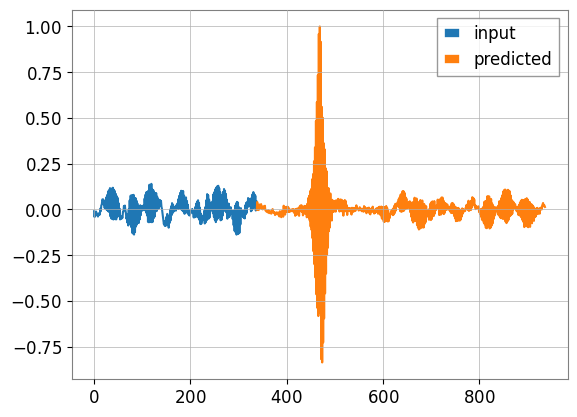

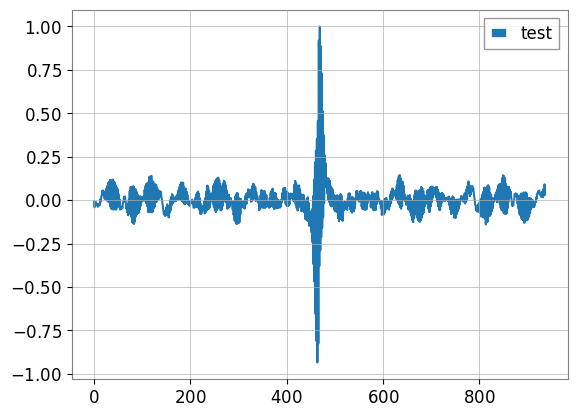

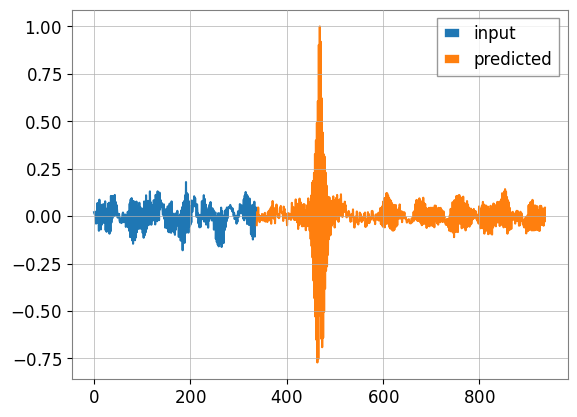

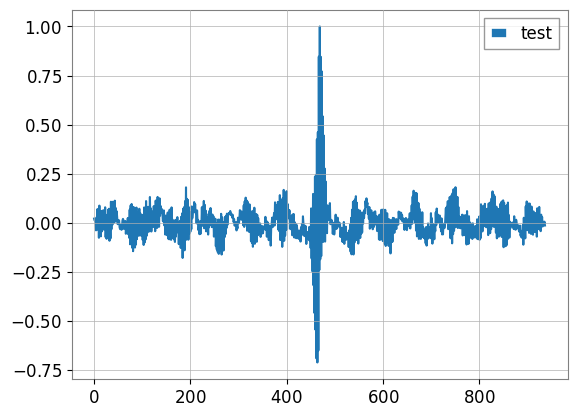

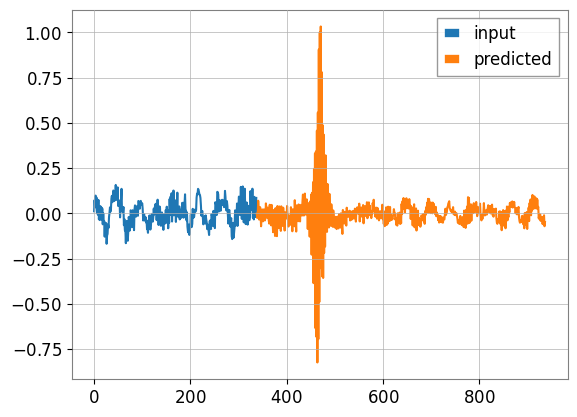

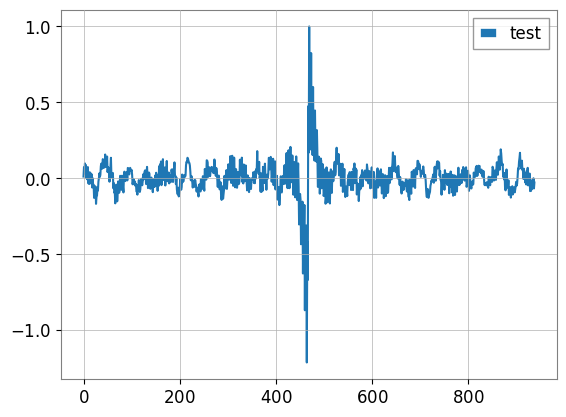

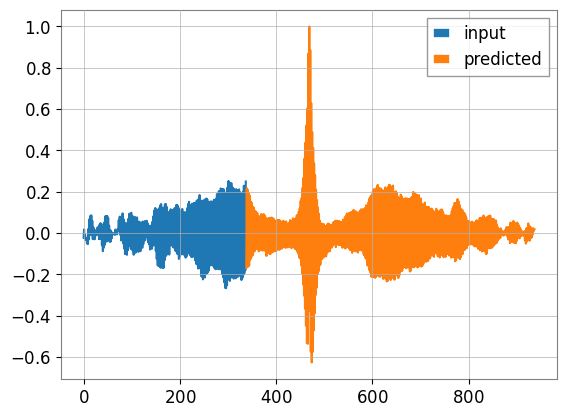

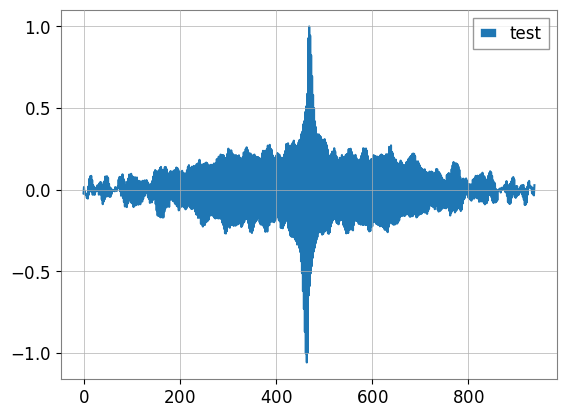

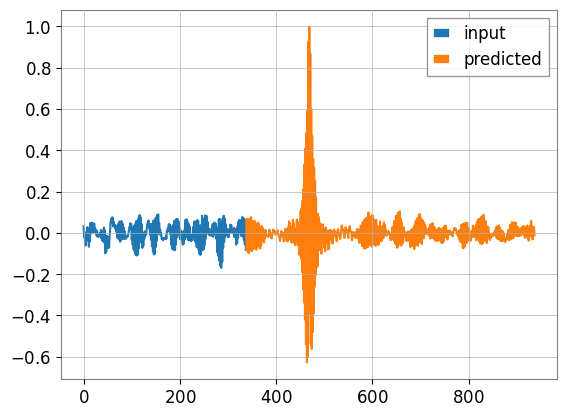

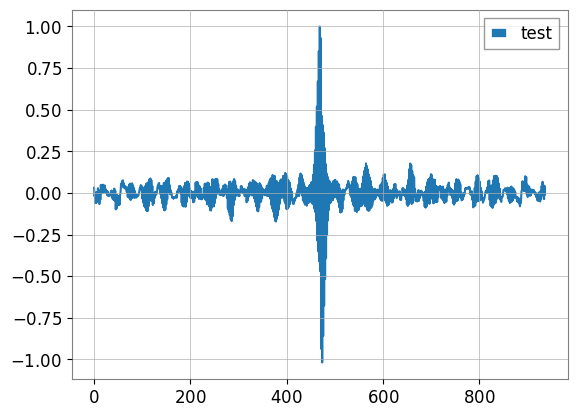

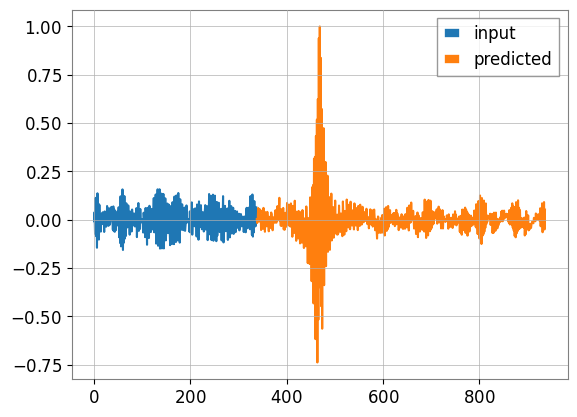

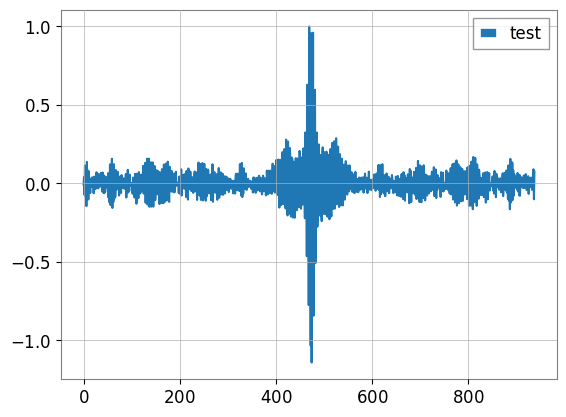

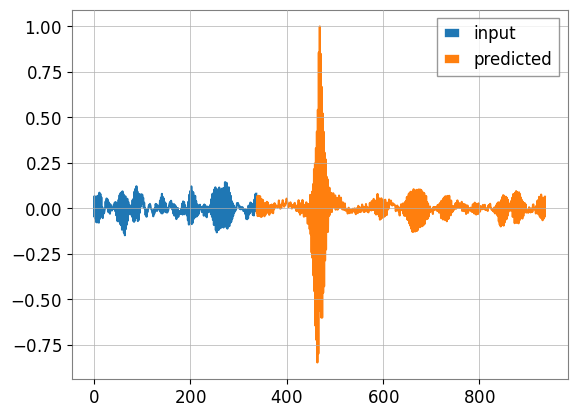

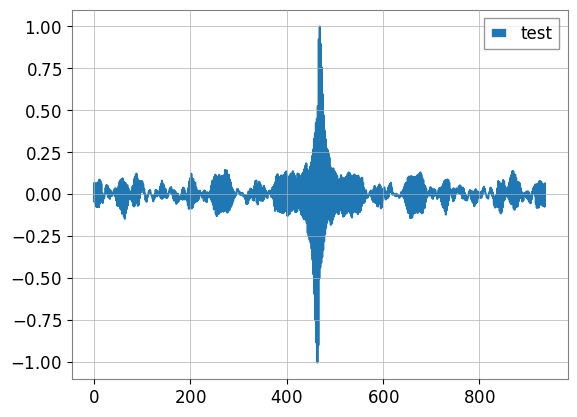

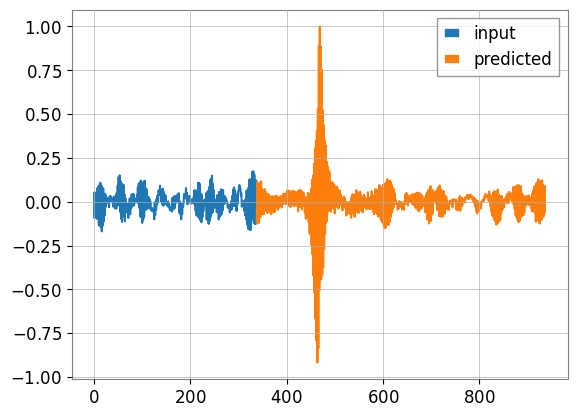

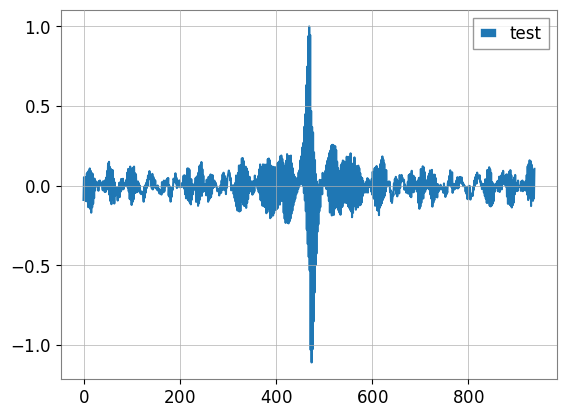

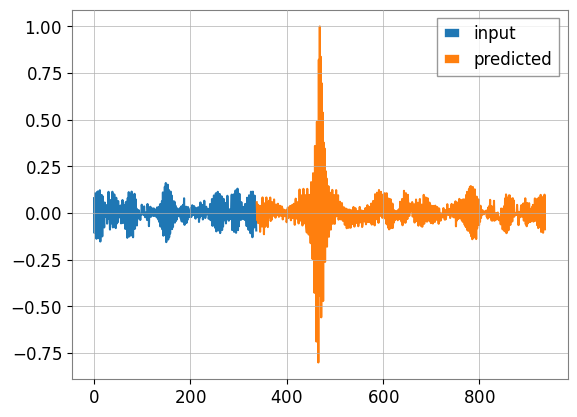

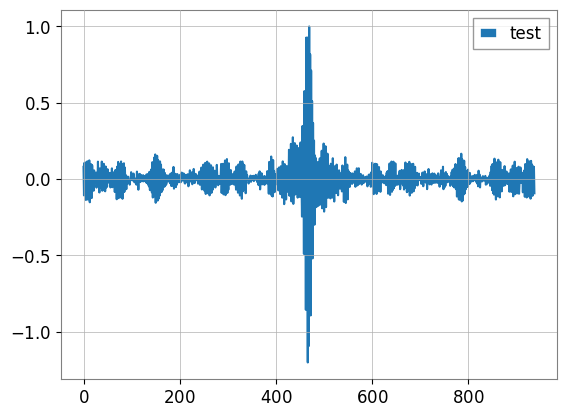

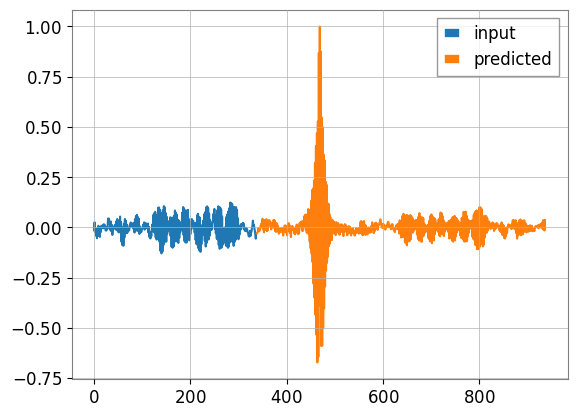

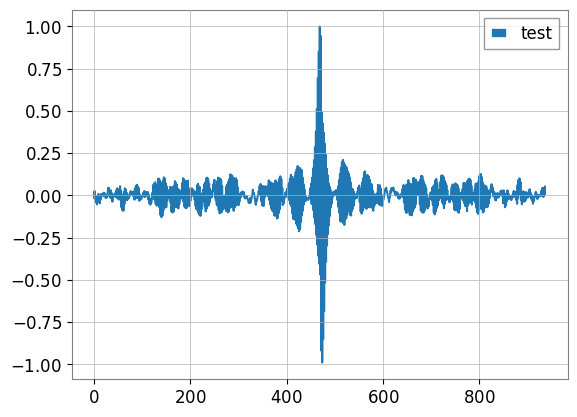

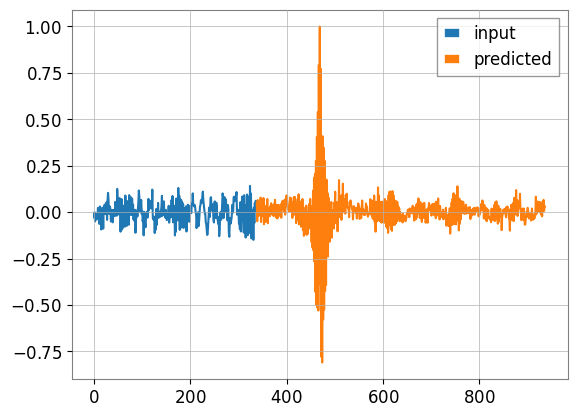

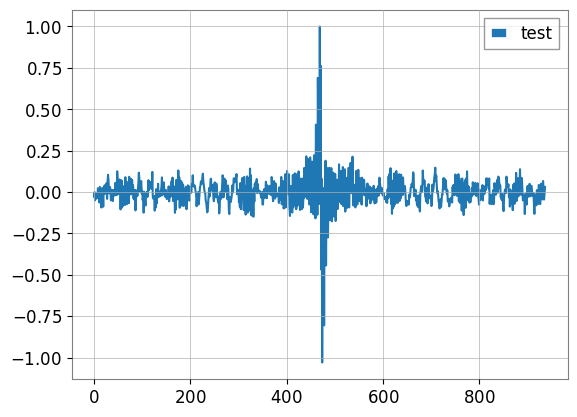

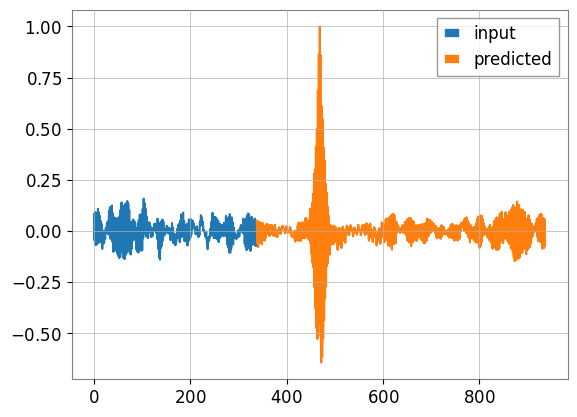

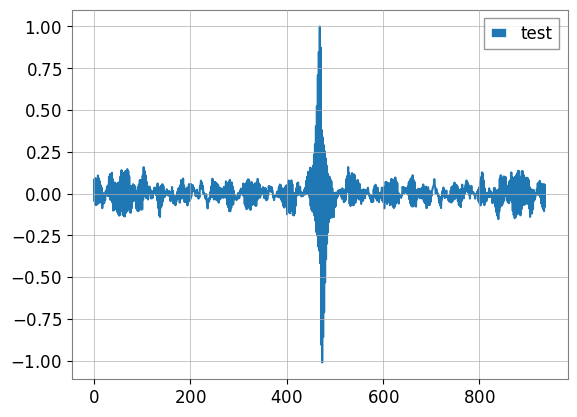

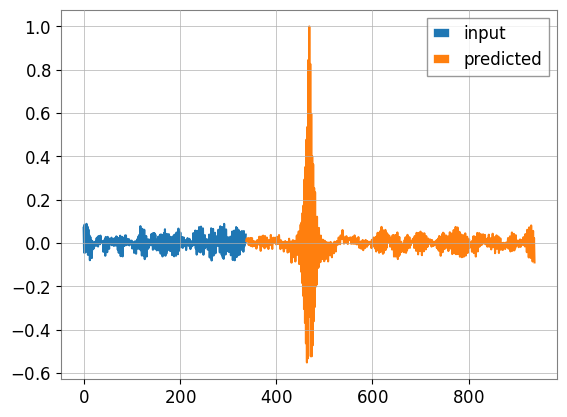

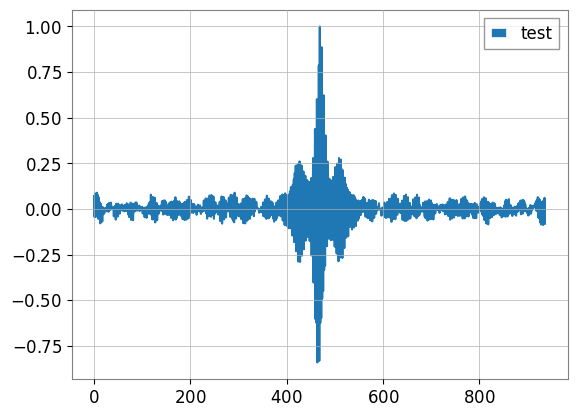

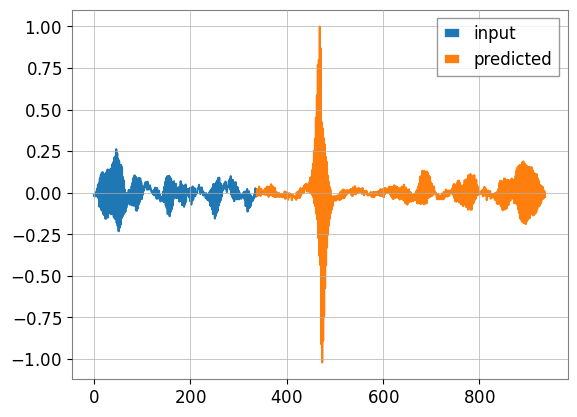

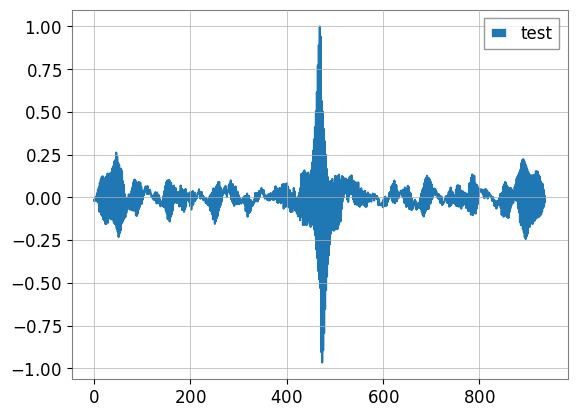

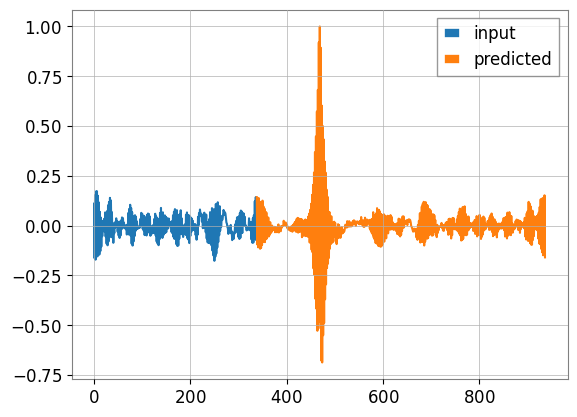

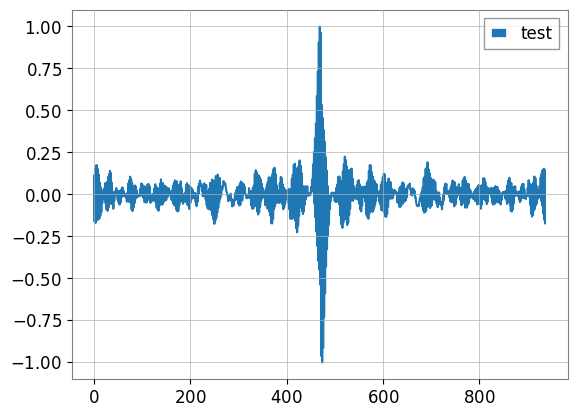

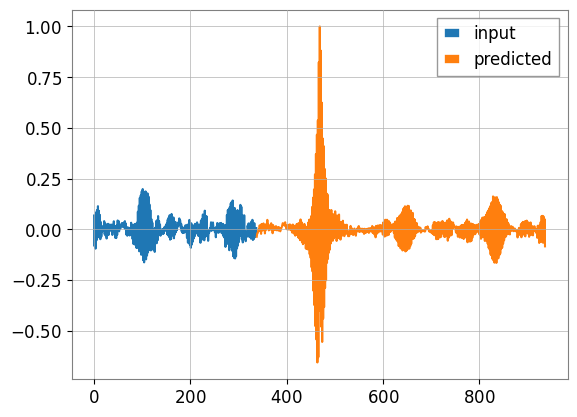

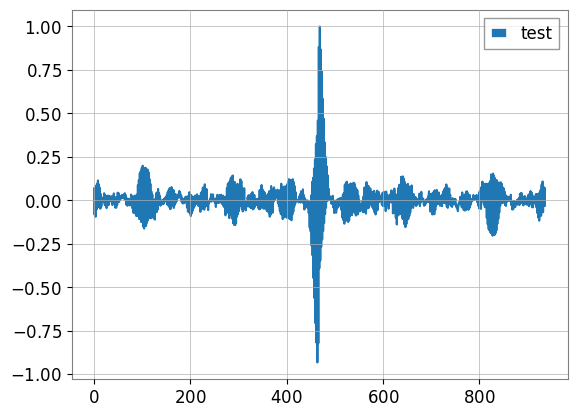

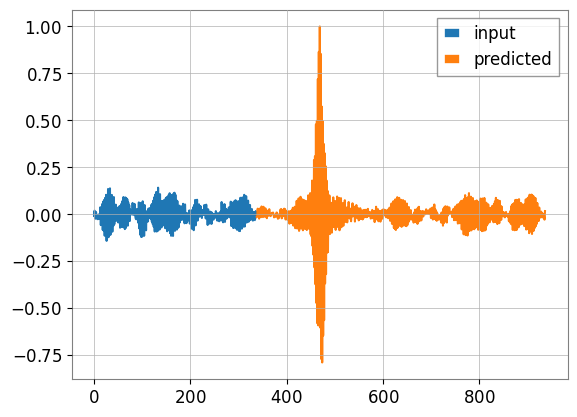

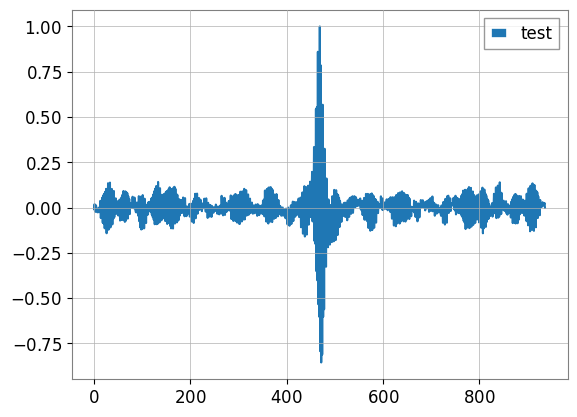

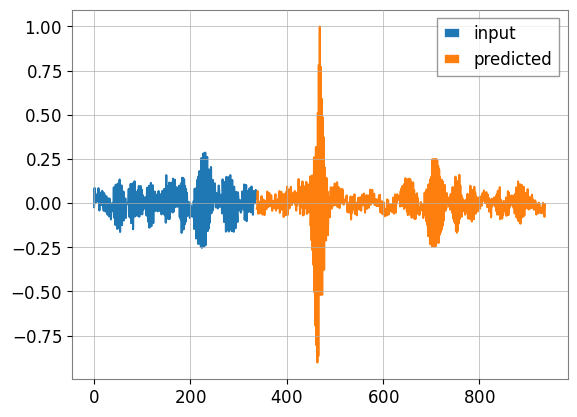

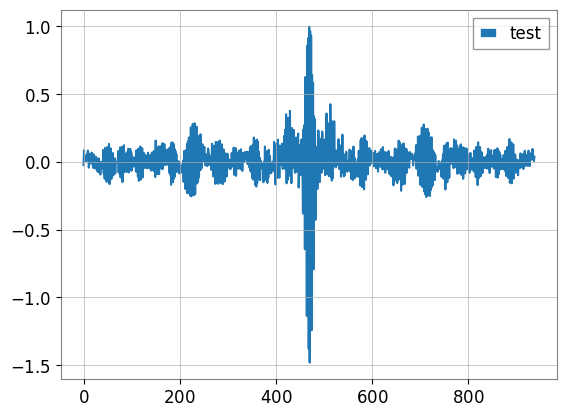

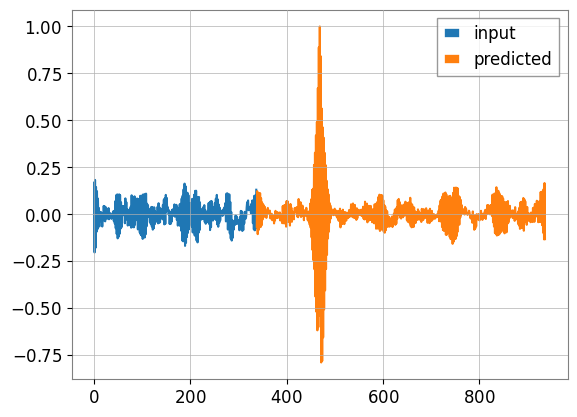

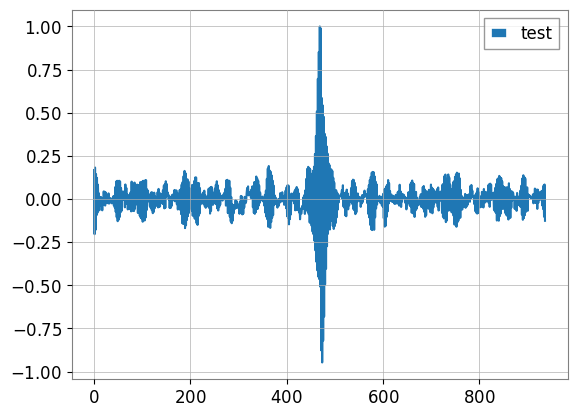

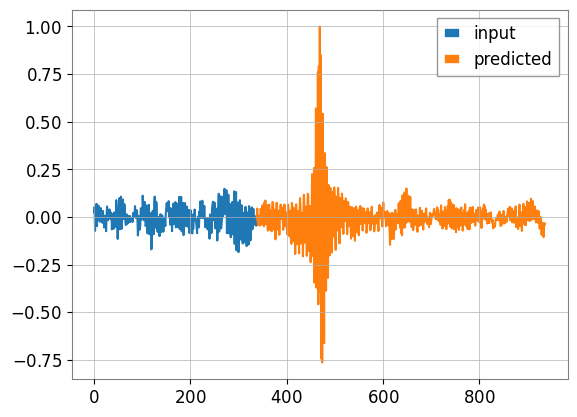

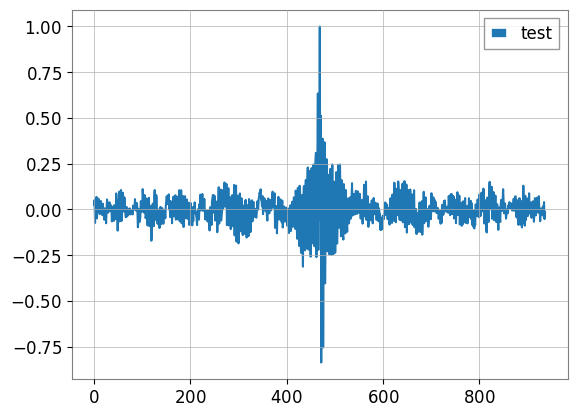

In [20]:
for i in range(20):
    input_series, predicted =validation[:,:data_split],prediction[i]
    plt.plot(validation[i,:data_split],label='input')
    plt.plot(np.arange(data_split,data.shape[1],1),predicted.detach().cpu().numpy(),label='predicted')
    plt.legend()
    plt.show()
    plt.plot(validation[i],label='test')
    plt.legend()
    plt.show()